In [2]:
!pip install contractions
!pip install Levenshtein
!pip install fuzzywuzzy
!pip install pot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 10.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import Libraries

import pandas as pd
import numpy as np                                              

import re
import contractions
from bs4 import BeautifulSoup
import string

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import fuzz
import Levenshtein
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from ot import emd2

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
colors = ['firebrick', 'tomato']

import gc

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
# Load data

df = pd.read_csv('/content/drive/MyDrive/cleaned_data.csv')
df.head()

,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question_len_diff
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37


In [6]:
df.shape

(404266, 8)

## **Data Preparation**

---



In [9]:
X = df.drop(['is_duplicate', 'qid1', 'qid2'], axis = 1)
y = df['is_duplicate']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (323412, 5)
Testing set shape: (80854, 5)


## **Preprocessing**

In [10]:
# Define a function that replaces numbers with string equivalents
def replace_numbers(match):
    number = match.group(0)
    if number.endswith('000000000'):
        return number[:-9] + 'b'
    elif number.endswith('000000'):
        return number[:-6] + 'm'
    elif number.endswith('000'):
        return number[:-3] + 'k'
    else:
        return number

def preprocess(q):
    q = q.lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents
    q = re.sub(r'\b[0-9]+(000000000|000000|000)\b', replace_numbers, q)

    # Decontracting words
    q = contractions.fix(q)

    try:
        # Removing HTML tags
        q = BeautifulSoup(q, features="html.parser").get_text()
    except:
        pass
        
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q)

    # Tokenization and POS tagging
    tokens = word_tokenize(q)
    pos_tags = nltk.pos_tag(tokens)

    # Remove stop words and lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()   

    tokens = [lemmatizer.lemmatize(word) for word, pos in pos_tags if word not in stop_words]

    return tokens, pos_tags


In [11]:
# Apply preprocessing to train
X_train['clean_text1'], X_train['pos_tags1'] = zip(*X_train['question1'].apply(lambda x: preprocess(x) if isinstance(x, str) else ([], [])))
X_train['clean_text2'], X_train['pos_tags2'] = zip(*X_train['question2'].apply(lambda x: preprocess(x) if isinstance(x, str) else ([], [])))

# Apply preprocessing to test
X_test['clean_text1'], X_test['pos_tags1'] = zip(*X_test['question1'].apply(lambda x: preprocess(x) if isinstance(x, str) else ([], [])))
X_test['clean_text2'], X_test['pos_tags2'] = zip(*X_test['question2'].apply(lambda x: preprocess(x) if isinstance(x, str) else ([], [])))


In [40]:
# Sample of the preprocessed data

X_train[['question1', 'clean_text1', 'pos_tags1', 'question2', 'clean_text2', 'pos_tags2']].head(3)

,question1,clean_text1,pos_tags1,question2,clean_text2,pos_tags2
0,What do you think about Nicki Minaj?,"[think, nicki, minaj]","[(what, WP), (do, VBP), (you, PRP), (think, VB...",What is the appeal of Nicki Minaj?,"[appeal, nicki, minaj]","[(what, WP), (is, VBZ), (the, DT), (appeal, NN..."
1,"Do atheists believe in palmistry, numerology, ...","[atheist, believe, palmistry, numerology, astr...","[(do, VBP), (atheists, NNS), (believe, VB), (i...",Do some atheists believe in astrology?,"[atheist, believe, astrology]","[(do, VB), (some, DT), (atheists, NNS), (belie..."
2,Where can I gain a SAFe agilist certification ...,"[gain, safe, agilist, certification, london]","[(where, WRB), (can, MD), (i, VB), (gain, VB),...","How safe is it to live in Fulham, London?","[safe, live, fulham, london]","[(how, WRB), (safe, JJ), (is, VBZ), (it, PRP),..."


In [13]:
gc.collect()

2254

### **Word Cloud for 'clean_text1' and 'clean_text2'**

**Train**

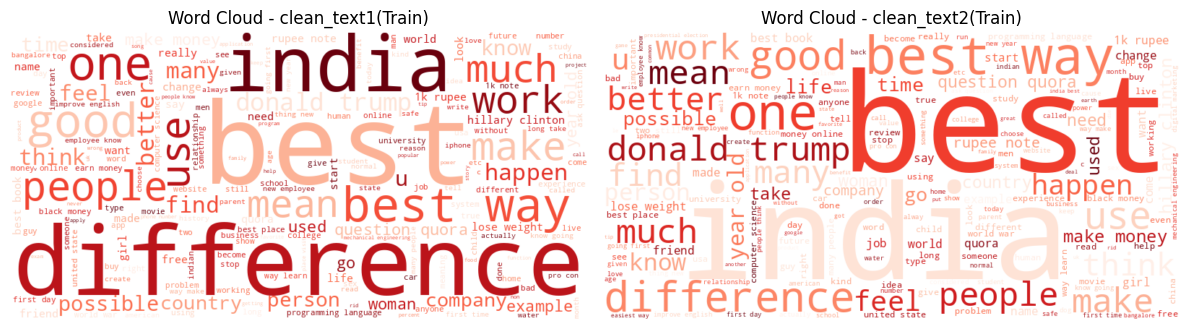

In [14]:
# Join tokens to form strings
clean_text1_str1 = [' '.join(tokens) for tokens in X_train['clean_text1']]
clean_text2_str1 = [' '.join(tokens) for tokens in X_train['clean_text2']]

# Generate word clouds for 'tokens_q1' and 'tokens_q2'
wordcloud_q1 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(clean_text1_str1))
wordcloud_q2 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(clean_text2_str1))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_q1, interpolation='bilinear')
plt.title("Word Cloud - clean_text1(Train)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_q2, interpolation='bilinear')
plt.title("Word Cloud - clean_text2(Train)")
plt.axis("off")

plt.tight_layout()
plt.show()


**Test**

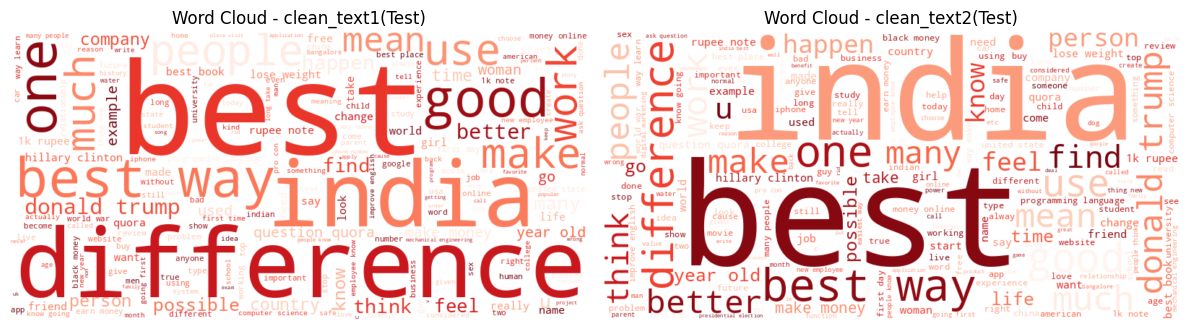

In [15]:
# Join tokens to form strings
clean_text1_str2 = [' '.join(tokens) for tokens in X_test['clean_text1']]
clean_text2_str2 = [' '.join(tokens) for tokens in X_test['clean_text2']]

# Generate word clouds for 'tokens_q1' and 'tokens_q2'
wordcloud_q1 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(clean_text1_str1))
wordcloud_q2 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(clean_text2_str1))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_q1, interpolation='bilinear')
plt.title("Word Cloud - clean_text1(Test)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_q2, interpolation='bilinear')
plt.title("Word Cloud - clean_text2(Test)")
plt.axis("off")

plt.tight_layout()
plt.show()

## **Feature Extraction**

In [16]:
# Define a function that extracts features from the questions 

def calculate_features(data):
    features = []

    for index, row in data.iterrows():
        question1 = str(row['question1'])
        question2 = str(row['question2'])

        # Sentence count
        sentence_count1 = len(sent_tokenize(question1))
        sentence_count2 = len(sent_tokenize(question2))

        # Percentage of common tokens
        tokens1 = word_tokenize(question1)
        tokens2 = word_tokenize(question2)
        common_tokens = len(set(tokens1) & set(tokens2))
        percentage_common_tokens = common_tokens / min(len(tokens1), len(tokens2))

        # Number of capital letters & Number of question marks
        num_capital_letters1 = sum(1 for char in question1 if char.isupper())
        num_capital_letters2 = sum(1 for char in question2 if char.isupper())
        num_question_marks1 = question1.count('?')
        num_question_marks2 = question2.count('?')

        # If questions start with are, can, how
        starts_with_are = question1.lower().startswith('are') or question2.lower().startswith('are')
        starts_with_can = question1.lower().startswith('can') or question2.lower().startswith('can')
        starts_with_how = question1.lower().startswith('how') or question2.lower().startswith('how')

        feature_row = [percentage_common_tokens, sentence_count1, sentence_count2, num_capital_letters1, num_capital_letters2,
                       num_question_marks1, num_question_marks2, starts_with_are, starts_with_can, starts_with_how]

        features.append(feature_row)
    return features

X_train_features = calculate_features(X_train)
feature_columns = ['percentage_common_tokens', 'sentence_count1', 'sentence_count2', 'num_capital_letters1', 'num_capital_letters2',
                   'num_question_marks1', 'num_question_marks2', 'starts_with_are', 'starts_with_can', 'starts_with_how']

X_train_features = pd.DataFrame(X_train_features, columns=feature_columns)
X_train_features.reset_index(drop=True, inplace=True)

X_test_features = calculate_features(X_test)
X_test_features = pd.DataFrame(X_test_features, columns=feature_columns)
X_test_features.reset_index(drop=True, inplace=True)

# Merge feature DataFrames with X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), X_train_features], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_features], axis=1)

X_train[['starts_with_are', 'starts_with_can', 'starts_with_how']] = X_train[['starts_with_are', 'starts_with_can', 'starts_with_how']].astype(int)
X_test[['starts_with_are', 'starts_with_can', 'starts_with_how']] = X_test[['starts_with_are', 'starts_with_can', 'starts_with_how']].astype(int)


In [17]:
# Sample of the extracted features

X_train[['percentage_common_tokens', 'sentence_count1', 'sentence_count2', 'num_capital_letters1',
         'num_capital_letters2','num_question_marks1', 'num_question_marks2', 'starts_with_are', 'starts_with_can', 'starts_with_how']].sample(3)

,percentage_common_tokens,sentence_count1,sentence_count2,num_capital_letters1,num_capital_letters2,num_question_marks1,num_question_marks2,starts_with_are,starts_with_can,starts_with_how
20310,0.545455,1,1,4,6,1,1,0,0,0
157992,0.600000,1,1,3,3,1,1,0,0,0
204003,0.500000,1,1,2,4,1,1,0,0,0


In [18]:
gc.collect()

10998

In [19]:
# A function that extracts features from generated tokens 'clean_text1' and 'clean_text2'

def calculate_features2(data):

    features = []

    for index, row in data.iterrows():
        text1 = row['clean_text1']
        text2 = row['clean_text2']

        word_count1, word_count2 = len(text1), len(text2)
        avg_word_length1 = sum(len(word) for word in text1) / len(text1) if len(text1) > 0 else 0
        avg_word_length2 = sum(len(word) for word in text2) / len(text2) if len(text2) > 0 else 0

        unique_word_count = len(set(text1).union(set(text2)))
        similar_word_count = len(set(text1).intersection(set(text2)))

        fuzzy_word_partial_ratio = fuzz.partial_ratio(' '.join(text1), ' '.join(text2))
        token_set_ratio = fuzz.token_set_ratio(' '.join(text1), ' '.join(text2))
        token_sort_ratio = fuzz.token_sort_ratio(' '.join(text1), ' '.join(text2))

        unique_words1 = set(text1)
        unique_words2 = set(text2)
        intersection = unique_words1.intersection(unique_words2)
        denominator = len(unique_words1) + len(unique_words2)
        word_overlap = len(intersection) / denominator if denominator > 0 else 0
        jaccard_similarity = len(intersection) / (len(unique_words1.union(unique_words2))) if denominator > 0 else 0

        levenshtein_distance = fuzz.ratio(' '.join(text1), ' '.join(text2))


        feature_row = [word_count1, word_count2, avg_word_length1,
                                 avg_word_length2, unique_word_count, similar_word_count, fuzzy_word_partial_ratio,
                                 token_set_ratio, token_sort_ratio, word_overlap, jaccard_similarity,
                                 levenshtein_distance]
        features.append(feature_row)

    return features

feature_columns = ['word_count1', 'word_count2', 'avg_word_length1',
                       'avg_word_length2', 'unique_word_count', 'similar_word_count', 'fuzzy_word_partial_ratio',
                       'token_set_ratio', 'token_sort_ratio', 'word_overlap', 'jaccard_similarity',
                       'levenshtein_distance']

X_train_features = calculate_features2(X_train)
X_train_features = pd.DataFrame(X_train_features, columns=feature_columns)
X_train_features.reset_index(drop=True, inplace=True)

X_test_features = calculate_features2(X_test)
X_test_features = pd.DataFrame(X_test_features, columns=feature_columns)
X_test_features.reset_index(drop=True, inplace=True)

# Merge feature DataFrames with X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), X_train_features], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_features], axis=1)

In [20]:
# Sample of extracted features

X_test[['word_count1', 'word_count2', 'avg_word_length1', 'avg_word_length2', 'unique_word_count',
        'similar_word_count', 'fuzzy_word_partial_ratio','token_set_ratio', 'token_sort_ratio', 
        'word_overlap', 'jaccard_similarity', 'levenshtein_distance']].sample(3)

,word_count1,word_count2,avg_word_length1,avg_word_length2,unique_word_count,similar_word_count,fuzzy_word_partial_ratio,token_set_ratio,token_sort_ratio,word_overlap,jaccard_similarity,levenshtein_distance
35992,8,8,5.5,5.375,9,7,90,94,87,0.437500,0.777778,91
76912,3,3,9.0,9.000,4,2,86,93,86,0.333333,0.500000,86
39400,3,3,5.0,6.000,4,2,82,87,76,0.333333,0.500000,76


In [21]:
gc.collect()

0

In [22]:
# A function that extracts additional features

def calculate_features3(data):
    features = []

    for index, row in data.iterrows():
        text1 = row['clean_text1']
        text2 = row['clean_text2']

        length_ratio = len(text1) / len(text2) if len(text2) != 0 else 0

        ngrams2 = set(ngrams(text2, 2))
        common_2grams = len(set(ngrams(text1, 2)).intersection(ngrams2)) / len(ngrams2) if len(ngrams2) != 0 else 0

        ngrams2 = set(ngrams(text2, 3))
        common_3grams = len(set(ngrams(text1, 3)).intersection(ngrams2)) / len(ngrams2) if len(ngrams2) != 0 else 0

        feature_row = [length_ratio, common_2grams, common_3grams]

        features.append(feature_row)

    return features

feature_columns = ['length_ratio', 'common_2grams', 'common_3grams']

X_train_features = calculate_features3(X_train)
X_train_features = pd.DataFrame(X_train_features, columns=feature_columns)
X_train_features.reset_index(drop=True, inplace=True)

X_test_features = calculate_features3(X_test)
X_test_features = pd.DataFrame(X_test_features, columns=feature_columns)
X_test_features.reset_index(drop=True, inplace=True)

# Merge feature DataFrames with X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), X_train_features], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_features], axis=1)


In [23]:
# Sample of extracted features 

X_train[['length_ratio', 'common_2grams', 'common_3grams']].sample(3)

,length_ratio,common_2grams,common_3grams
321749,1.000000,0.5,0.00
136127,1.200000,0.5,0.00
52971,1.166667,0.4,0.25


In [24]:
gc.collect()

0

In [25]:
# Display summary statistics

X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
question1_len,323412.0,59.534377,29.975120,2.0,39.000000,52.000000,72.000000,623.000000
question2_len,323412.0,60.125196,33.915721,2.0,39.000000,51.000000,72.000000,1169.000000
question_len_diff,323412.0,20.159536,25.605979,0.0,4.000000,12.000000,26.000000,1080.000000
percentage_common_tokens,323412.0,0.568383,0.241008,0.0,0.380952,0.571429,0.750000,1.000000
sentence_count1,323412.0,1.104795,0.369788,1.0,1.000000,1.000000,1.000000,9.000000
sentence_count2,323412.0,1.129241,0.437355,1.0,1.000000,1.000000,1.000000,22.000000
num_capital_letters1,323412.0,2.714262,2.410898,0.0,1.000000,2.000000,3.000000,111.000000
num_capital_letters2,323412.0,2.761904,2.436614,0.0,1.000000,2.000000,4.000000,100.000000
num_question_marks1,323412.0,1.051043,0.240932,0.0,1.000000,1.000000,1.000000,6.000000
num_question_marks2,323412.0,1.057478,0.256419,0.0,1.000000,1.000000,1.000000,6.000000


In [26]:
# Display rows with zero tokens
    
zero_tokens_rows_train = X_train[(X_train['word_count1'] == 0) | (X_train['word_count2'] == 0) ]

print(len(zero_tokens_rows_train))
print(zero_tokens_rows_train)

103
                                                question1  \
17020                              Why can't I be myself?   
18928                           How can I just be myself?   
19090                                                Why?   
21500                                                 Is?   
21846                                                What   
...                                                   ...   
302941               Is it "if she was" or "if she were"?   
304899  Why does the page reload every time I try to c...   
309554                               What is amygdaloida?   
310464                                               Can?   
320961                                                How   

                                                question2  question1_len  \
17020                       Why can't I think for myself?             22   
18928                         How can I always be myself?             25   
19090                          Why 

In [27]:
zero_tokens_rows_test = X_test[(X_test['word_count1'] == 0) | (X_test['word_count2'] == 0) ]

print(len(zero_tokens_rows_test))
print(zero_tokens_rows_test)

19
                                               question1  \
3311                                      What is quoro?   
9536   Are these normal errors for a non-native Engli...   
20717                                     Me before you?   
28411                                 What is "what is"?   
31507                 What is what and why is that what?   
34725  What's the difference between an editorial, co...   
35057                                     What is quoro?   
37639                  What's the ethnicity of this boy?   
38782                                Where are you from?   
39567  Does the Quran surah 23: 5-6 prove that Allah ...   
39942                                        What is)'(?   
45098                        What is here and not there?   
54466  Is there a Bible or New Testament that is writ...   
62379                                                …..   
62530         What should I do about not feeling pretty?   
64441                   Why is it tha

These rows will not provide much information for our question similarity problem

In [28]:
# Drop the zero word count rows

X_train = X_train.drop(zero_tokens_rows_train.index)
X_test = X_test.drop(zero_tokens_rows_test.index)

print(X_train.shape)
print(X_test.shape)

(323309, 34)
(80835, 34)


In [29]:
gc.collect()

0

### **Glove Embeddings**

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [30]:
glove_file = '/content/drive/MyDrive/embeddings/glove.6B.300d.txt' 
word2vec_file = 'glove.6B.300d.word2vec'  # Output file for converted word2vec format

# Convert the GloVe file to the word2vec format
glove2word2vec(glove_file, word2vec_file)
wv = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)

# Total number of vocabulary words in the pretrained model
vocab_size = len(wv.index_to_key)
print("Vocabulary size:", vocab_size)

# Dimensionality of the word vectors
vector_dim = wv.vector_size
print("Vector dimension:", vector_dim)


Vocabulary size: 400000
Vector dimension: 300


In [31]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

# Function that computes similarity between the tokens and the word vectors   
def compute_similarity(df, tokens_q1, tokens_q2, wv, vector_dim):
    similarities = []
    
    for tokens1, tokens2 in zip(tokens_q1, tokens_q2):
        embedding1 = np.zeros((vector_dim,))
        embedding2 = np.zeros((vector_dim,))
        
        # Compute embedding for question 1
        for token in tokens1:
            if token in wv:
                embedding1 += wv[token]
        if len(tokens1) > 0:
            embedding1 /= len(tokens1)
        
        # Compute embedding for question 2
        for token in tokens2:
            if token in wv:
                embedding2 += wv[token]
        if len(tokens2) > 0:
            embedding2 /= len(tokens2)
        
        # Check if embeddings are all zeros
        if np.all(embedding1 == 0) or np.all(embedding2 == 0):
            similarity = 0.0
        else:
            similarity = cosine_similarity(embedding1, embedding2)
        
        similarities.append(similarity)
    
    return similarities

X_train['cosine_similarity'] = compute_similarity(X_train, X_train['clean_text1'], X_train['clean_text2'], wv, vector_dim)
X_test['cosine_similarity'] = compute_similarity(X_test, X_test['clean_text1'], X_test['clean_text2'], wv, vector_dim)


In [32]:
X_train['cosine_similarity'].describe()

count    323309.000000
mean          0.783834
std           0.193446
min          -0.337947
25%           0.712462
50%           0.835641
75%           0.917563
max           1.000000
Name: cosine_similarity, dtype: float64

In [33]:
X_test['cosine_similarity'].describe()

count    80835.000000
mean         0.784480
std          0.192879
min         -0.332108
25%          0.714241
50%          0.836387
75%          0.917928
max          1.000000
Name: cosine_similarity, dtype: float64

In [34]:
# Function to calculate word similarity with embeddings using POS tags

def calculate_word_similarity(pos_tag_q1, pos_tag_q2):
    combined_pos_q1 = ' '.join([pos[0].lower() + '_' + pos[1] for pos in pos_tag_q1])
    combined_pos_q2 = ' '.join([pos[0].lower() + '_' + pos[1] for pos in pos_tag_q2])
    if combined_pos_q1 and combined_pos_q2:
        return wv.wmdistance(combined_pos_q1, combined_pos_q2)
    else:
        return np.nan

X_train['word_similarity'] = X_train.apply(lambda row: calculate_word_similarity(row['pos_tags1'], row['pos_tags2']), axis=1)
X_test['word_similarity'] = X_test.apply(lambda row: calculate_word_similarity(row['pos_tags1'], row['pos_tags2']), axis=1)


In [35]:
X_train['word_similarity'].head(3)

0    0.289466
1    0.158326
2    0.304761
Name: word_similarity, dtype: float64

In [36]:
gc.collect()

0

**Correlation**

In [37]:
correlation_matrix = X_train.corr()

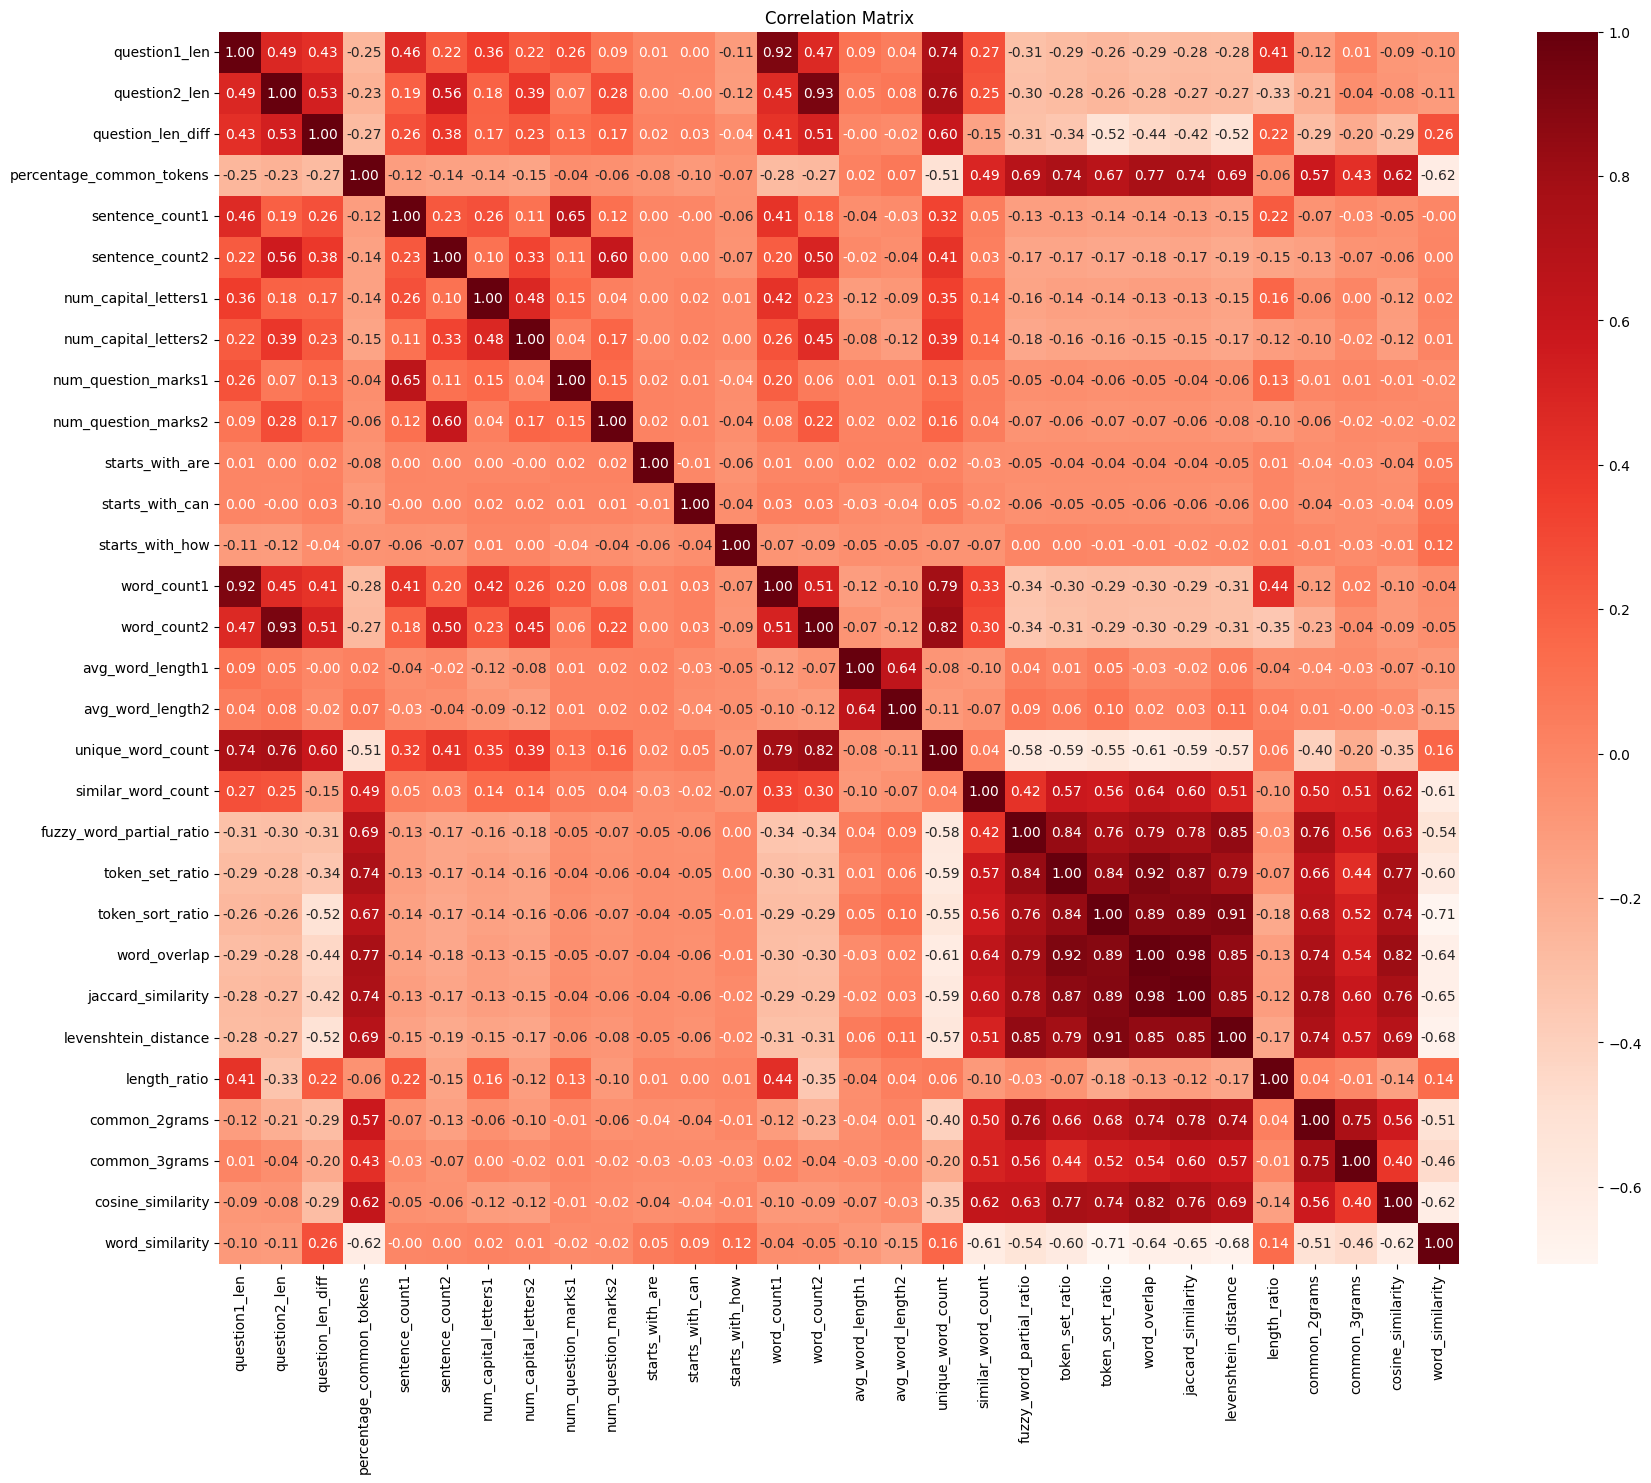

In [38]:
plt.figure(figsize=(20, 16))

# Create a heatmap 
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt=".2f")

plt.title('Correlation Matrix')
plt.show()

**VIF - Test for multicollinearity**

In [44]:
X = X_train.drop(['question1', 'question2', 'clean_text1', 'clean_text2', 'pos_tags1', 'pos_tags2', 'word_overlap', 'question1_len', 'question2_len', 'unique_word_count'], axis=1)

# Add a constant column to the DataFrame
X = sm.add_constant(X)

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF results
print(vif)

                    Variable         VIF
0                      const  280.443770
1          question_len_diff    2.931372
2   percentage_common_tokens    3.116340
3            sentence_count1    2.203747
4            sentence_count2    2.292253
5       num_capital_letters1    1.574543
6       num_capital_letters2    1.641891
7        num_question_marks1    1.826116
8        num_question_marks2    1.664224
9            starts_with_are    1.015347
10           starts_with_can    1.022614
11           starts_with_how    1.052092
12               word_count1    6.248686
13               word_count2    7.046977
14          avg_word_length1    1.754196
15          avg_word_length2    1.785270
16        similar_word_count    5.572551
17  fuzzy_word_partial_ratio    8.353619
18           token_set_ratio    9.961766
19          token_sort_ratio   11.143328
20        jaccard_similarity   10.961659
21      levenshtein_distance   11.670561
22              length_ratio    4.273063
23             c

The variables exihibit very VIF values

In [ ]:
# Reset the indices of X_train and y_train
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Concatenate X_train with y_train
train_df = pd.concat([X_train, y_train], axis=1)

# Reset the indices of X_test and y_test
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Concatenate X_test with y_test
test_df = pd.concat([X_test, y_test], axis=1)

### **Save train and test**

In [ ]:
train_path = '/content/drive/MyDrive/clean_data_traindf.csv'
test_path = '/content/drive/MyDrive/clean_data_test.csv'
train_df.to_csv('traindf', index=False)
test_df.to_csv('testdf', index=False)